# Persist Benchmarks

In [17]:
# select measurement file
files = [
    "../output/2024-12-23 16-47-29.json",
]

# plot settings
show_error_bar = False
unit = "ms"

In [18]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [19]:
from util.convert import convert_datasets
import pandas as pd

storage = convert_datasets(
    raw_data,
    "Storage",
    [("persistent_storage_write", "Storage Write")],
    ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

baseline = convert_datasets(
    raw_data,
    "Persist",
    [("max_dirty_persist_latency_dirty_size", "Worst Case"), ("max_dirty_persist_latency_buffer_size", "Worst Case Buffer")],
    ["mean", "min", "max", "options.dirty_size", "options.buffer_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

dataset = pd.concat([storage, baseline])
dataset.head()

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id,options.dirty_size,options.buffer_size
0,374.3,374,375,0.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
1,9694.0,9173,14378,16.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
2,14662.9,14142,19347,32.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
3,19631.6,19111,24316,48.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN
4,24600.4,24080,29284,64.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN


In [20]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        23.39375
max    159296.93750
Name: mean, dtype: float64

min      452.37500
max    79108.36875
Name: mean, dtype: float64

min     4360.3125
max    39242.7125
Name: mean, dtype: float64

# Final Plot

In [21]:
scale = 0.5
scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] = scaled_dataset["options.object_size"]/1024
scaled_dataset["options.dirty_size"] = scaled_dataset["options.dirty_size"]/1024

storage_dataset = scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= 4) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)].copy()
storage_dataset["mean"] = storage_dataset["mean"].max()

plot_data = [{
    "name": "Raw Storage",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "use_edge_color": True,
    "data": storage_dataset,
},{
    "name": "vNV-Heaps",
    "x": "options.dirty_size",
    "y": "mean",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)],
}]
buf_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)]["options.buffer_size"]
assert(len(buf_size.unique()) == 1)
buf_size = buf_size.unique()[0] / 1024

options1 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Dirty Size [kB]",
    "y_label": f"Latency [{unit}]",
    "width": 1,
    "height": 0.4,
    "title": f"Fixed App Size: {int(buf_size)}kB"
}

In [22]:
scale = 0.5
limit = 4

scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] /= 1024
scaled_dataset["options.buffer_size"] /= 1024

plot_data = [{
    "name": "",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "use_edge_color": True,
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)],
},{
    "name": "",
    "x": "options.buffer_size",
    "y": "mean",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)],
}]

dirty_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)]["options.dirty_size"]
dirty_size = dirty_size.max() / 1024

options2 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "App Size [Byte]",
    "y_label": f"Latency [{unit}]",
    "width": 1,
    "height": 0.4,
    "title": f"Fixed Dirty Size: {int(dirty_size)}kB"
}

{'figure.facecolor': 'white', 'axes.labelcolor': '.15', 'xtick.direction': 'out', 'ytick.direction': 'out', 'xtick.color': '.15', 'ytick.color': '.15', 'axes.axisbelow': True, 'grid.linestyle': '-', 'text.color': '.15', 'font.family': ['sans-serif'], 'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'], 'lines.solid_capstyle': 'round', 'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'image.cmap': 'rocket', 'xtick.top': False, 'ytick.right': False, 'axes.grid': True, 'axes.facecolor': 'white', 'axes.edgecolor': '#ddd', 'grid.color': '#ddd', 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': False, 'ytick.left': False}


/home/markus/Documents/vnv_heap/zephyr/vnv_heap_benchmark/analysis/util/plot.py:178: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ncol = len(ax.legend().get_lines())


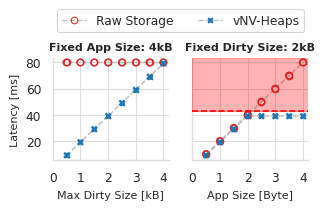

In [24]:
from util import convert
from util.plot import plot_lines, save_plot

axes = plot_lines([options1, options2])

offset_multiplier = 0.1
scaled = convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)], unit)
line = scaled["mean"].max() + scaled["mean"].max() * offset_multiplier

limit2 = (convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit)], unit))["mean"].max()
limit2 = limit2 + 0.04 * limit2

axes[1].axhline(line, ls='--', color="red", zorder=20)
axes[1].set_ylim(top=limit2)
axes[1].axhspan(line, limit2, alpha=0.3, color="red",zorder=10)
axes[0].legend(
    loc = "lower center",
    bbox_to_anchor=(1.1, 1.2),
    ncol=2,
    title=None,
    frameon=True
)
axes[1].get_legend().remove()


for ax in axes:
    ax.set_xticks([0,1,2,3,4])
    ax.set_xlim(0,4.2)

save_plot("persist", False)